BereaCubic


BereaCubic This example is reproduction of Ioannidis and Chatiz paper - Network Modelling of Pore Structure and Transport Properties of Porous Media.

A traditional Berea Sandstone on a Cubic lattice. Berea Sandstone is one of the standard materials used on geoscience studies due to it's importance in oil reservoir engineering as well as having well defined pore structure.  This class creates a Cubic Network with the appropriate lattice spacing and connectivity, then adds a Geometry object with the necessary pore-scale models and prescribed parameters.



In [7]:
import openpnm as op
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

OpenPNM V2 includes a ``materials`` module that contains *recipes* for numerous commonly used porous materials.  Because the network topology and geometry are tightly coupled, these recipes return both a ``network`` and a ``geometry``, packaged together in a ``project``.  This is illustrated for ``BereaCubic`` as follows:

In [ ]:
proj = op.materials.BereaCubic(shape=[15, 15, 15])
net = proj.network
geo = proj[1]

Fetch network shape and spacing for use later

In [ ]:
Lx, Ly, Lz = net.spacing
Nx, Ny, Nz = net.shape

Let's look at the distribution of pore and throat sizes in the system, and compare with those from the original paper:

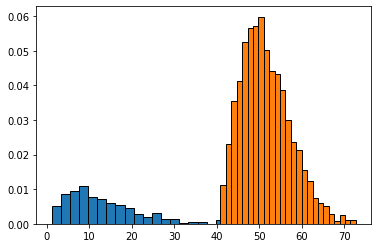

In [5]:
fig = plt.hist(x=geo['throat.size']*1e6, bins=25,
               weights=geo['throat.volume']*(1e3)**3, edgecolor='k')
fig = plt.hist(x=geo['pore.size_z']*1e6, bins=25,
               weights=geo['pore.volume']*(1e3)**3, edgecolor='k')

Next we'll run some simulations to validate the geometry against results in the source paper.  To do this we start by adding phase object that contain the physical properties of the fluids, and physics objects which will be *generic* classes to start and we'll add the appropriate models later:

In [9]:
hg = op.phases.Mercury(network=net)
air = op.phases.Air(network=net)
water = op.phases.Water(network=net)
hg['throat.contact_angle'] = 140
hg['throat.surface_tension'] = 0.48
water['throat.viscosity'] = 0.0001

phys_air = op.physics.GenericPhysics(network=net, phase=air, geometry=geo)
phys_hg = op.physics.GenericPhysics(network=net, phase=hg, geometry=geo)
phys_water = op.physics.GenericPhysics(network=net, phase=water, geometry=geo)


First, let's compare mercury intrusion capillary pressure curves.  One key feature of the original paper is that pore and throat bodies are cubes with a specified aspect ratio (i.e. flattened).  This shape affects both transport and capillary properties.  In terms of capillary pressure, the normally used Washburn eqauation ($Pc=-2\sigma cos(\theta) / R $) must be modified since the throat opening has two principle radii of curvature.  Thus, the capillary entry pressure is:

$$ Pc = -\sigma cos(\theta) \bigg(\frac{1}{R_1} + \frac{1}{R_2}\bigg) $$

This equation is implemented in ``openpnm.models.physics.capillary_pressure.washburn_slit``.  It is applied as follows:

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
    TIME STAMP: 2019-11-07 15:21:23,133    


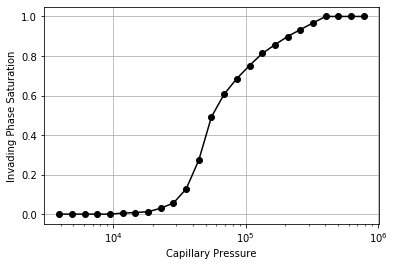

In [11]:
mod = op.models.physics.capillary_pressure.washburn_slit
phys_hg.add_model(propname='throat.entry_pressure', model=mod)

mip = op.algorithms.Porosimetry(network=net)
mip.setup(phase=hg)
mip.set_inlets(net.pores(['top', 'bottom']))
mip.run(points=25)
fig = mip.plot_intrusion_curve()

Now we can calculate directional permeability of the model. We have modified Hagen Poiseulle equation to calculate throat and pore hydraulic conductances using equations used in Marios paper. The equations are implemented in openpnm.models.physics.hydraulic_conductance.hagen_poiseuille_slit and are implemented as follows:

In [ ]:
mod = op.models.physics.hydraulic_conductance.hagen_poiseuille_slit
phys_water.add_model(propname='throat.hydraulic_conductance', model=mod)

alg = op.algorithms.StokesFlow(network=net, phase=water)
BC1_pores = net.pores('pore.front')
alg.set_value_BC(values=202650, pores=BC1_pores)
BC2_pores = net.pores('pore.back')
alg.set_value_BC(values=101325, pores=BC2_pores)
alg.run()
Q = alg.rate(pores=net.pores('front'))

A = (Ly*Lz)*(Ny*Nz)
L = Lx*Nx
mu = sp.mean(water['throat.viscosity'])
Kxx = Q*mu*L/(A*101325)
print("The permeability coefficient is:", Kxx/1e-15, 'mD')

Calculating porosity - Network porosity is the ratio of void volume (sum of throat and pore volumes) to the bulk volume and is implemented as follows: 

In [ ]:
Vp = geo['pore.volume'][net.Ps]
Vt = geo['throat.volume'][net.Ts]
Vps = sp.sum(Vp)
Vts = sp.sum(Vt)
Vt = Vps + Vts
Vb = Nx*Ny*Nz*Lx*Ly*Lz
e = Vt/Vb
print("The porosity is:", e)

Calculating Formation Factor - To calculate the Formation Factor we have made electrcal conductance model using a rectangular geometry for throats and square flattened geometry for the pores. For the pores we are using a truncated pyramid shape and average out the areas at the inlet and outlet. The equations are implemented in openpnm.models.physics.electrical_conductance.slit and are implemented as follows:

In [ ]:
mod = op.models.physics.electrical_conductance.slit
phys_water.add_model(propname='throat.electrical_conductance', model=mod)

Om = op.algorithms.OhmicConduction(network=net, phase=water)
BC1_pores = net.pores('pore.front')
Om.set_value_BC(values=20, pores=BC1_pores)
BC2_pores = net.pores('pore.back')
Om.set_value_BC(values=0, pores=BC2_pores)
Om.run()
I = Om.rate(pores=net.pores('front'))

A = (Ly*Lz)*Ny*Nz
L = Lx*Nx
delta_V = 20
Rnet = delta_V*A/(I*L)
F = Rnet
print("The formation factor is:", F)